In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import re as re
import os
import copy
import statsmodels.formula.api as sm
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Yurii\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Yurii\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv im

In [2]:
conflict = pd.read_csv('Data\\conflict_data\\DRC_2.csv', header = 0, index_col = 0)

aid = pd.read_csv('Data\\aid_data\\data\\level_1a.csv')
aid = aid.dropna(subset=['latitude', 'longitude', 'transactions_start_year']) # drop those entries that don't have coordinates and start year to them
#aid = aid.drop(aid[aid['transactions_start_year'] == ' '].index) # some projects don't have start year, so we drop those rows
aid = aid.drop(aid[aid['even_split_commitments'].isnull()].index) # some projects don't have info on commitments, so we drop those rows
aid['transactions_start_year'] = pd.to_numeric(aid['transactions_start_year'])

worker_deaths = pd.read_csv('Data\\security_incidents.csv', encoding = "ISO-8859-1")

provinces = gpd.read_file('Data\\gadm36_COD_shp/gadm36_COD_1.shp')

In [3]:
geometry = [Point(xy) for xy in zip(conflict.longitude, conflict.latitude)]
gconflict = gpd.GeoDataFrame(conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(aid.longitude, aid.latitude)]
gaid = gpd.GeoDataFrame(aid, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(worker_deaths.Longitude, worker_deaths.Latitude)]
g_w_d = gpd.GeoDataFrame(worker_deaths, crs = {'init': 'epsg:4326'}, geometry = geometry) # g_w_d = gworker_deaths


gconflict = gpd.sjoin(gconflict, provinces, how="inner")
gaid = gpd.sjoin(gaid, provinces, how="inner")
g_w_d = gpd.sjoin(g_w_d, provinces, how="inner")

# rename the column regarding the start year so that it corresponds to the name in casualties dataset
gaid = gaid.rename(columns = {'even_split_commitments': 'commitments', 'transactions_start_year': 'year'})

In [4]:
def plot_distances(year):
    min_dists = []
    for aid_project in gaid[gaid['transactions_start_year'] == year]['geometry']:
        min_dists.append(min(gconflict[gconflict['year'] == year + 1]['geometry'].distance(aid_project)))
    
    min_dists = pd.Series(min_dists) * 110
    
    #min_dists.plot.density()
    
    #plt.show()
    #print(min_dists.mean())
    #print(min_dists.median())
    return min_dists

In [5]:
distances = pd.Series()

for year in range(2000, 2014):
    try:  
        distances = distances.append(plot_distances(year))
    except:
        print(year)
        continue

#plt.show()

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [12]:
fig = plt.figure(figsize = (15, 15))
distances.plot.density()

plt.axvline(distances.mean(), color = 'r', linestyle = '--')
plt.text(distances.mean()+20,0.002,'mean = %i' % (distances.mean()), rotation=90, fontsize=20)

plt.axvline(distances.median(), color = 'orange', linestyle = '--')
plt.text(distances.median() + 5,0.002,'median %i' % (distances.median()),rotation=90, fontsize=20)
plt.savefig('Graphs\\NN_distance_DRC.png', bbox_inches='tight')

In [6]:
# calculate the number of rows there column_name has more than one entry, separated by "|". We use this for donors and aid focus. 
def calc_multiples(df, column_name):
    s = 0
    l = []
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            s += 1
            l.append(index)
    return s#, l

# split those rows that have more than one entry in a certain column name.
# We create a new row for each of the multiple entries (other entries being the same)
# and delete the original multiple entry row. 
def split_rows(data, column_name):
    df = copy.deepcopy(data)
    temp = pd.DataFrame()
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            for entry in entries:
                temp_row = row
                temp_row[column_name] = entry
                temp = temp.append(temp_row)
            df.drop(index, inplace = True)
            
    return df.append(temp)

# split the rows(projects) that have more than one donor per project
gaid = split_rows(gaid, 'donors')
gaid = split_rows(gaid, 'ad_sector_names')

In [7]:
if not os.path.exists('measures_indices'):
    os.makedirs('measures_indices')
    
# how many projects there are per donor and their share in the total, save in a csv file  
total = gaid['donors'].value_counts() # total N of projects per donor
share = gaid['donors'].value_counts() / gaid.shape[0] # calculate share of the projects per donor in total N of projects
pd.concat([total, share], axis = 1).to_csv('measures_indices\\N_projects_per_donor.csv')

# what share of projects per donor have multiple focus sectors (e.g. General environmental protection|Transport and storage)
multiple_focus_share = (gaid.groupby('donors').apply(calc_multiples, 'ad_sector_names') / gaid['donors'].value_counts())
multiple_focus_share.to_csv('measures_indices\\project_multiple_sectors.csv')

# share of each project focus in the total number of projects per donor. We use this to calculate variablity of project focus for a donor
focus_share = (gaid.groupby(['donors', 'ad_sector_names']).size() / gaid.groupby(['donors']).size())
focus_share.to_csv('measures_indices\\donor_sector_share.csv')

In [8]:
# Func calculates the coefficient of unalikeability (as defined by Kader 2007) of every sublcass of first_group variable by topic_name
# E.g. unalikeability of project location for each aid donor -> calc_unalikeability(gaid, 'donors', 'ad_sector_names')

def calc_unalikeability(data, first_group, topic_name):
    
    # prepare data: group by first_group and topic_name, and divide by the size of the respective group
    # thus we obtain the share that each topic_name has in the respective first_group
    
    d = (data.groupby([first_group, topic_name]).size() / gaid.groupby([first_group]).size())
    
    # here we get the keys for the first level grouping. So, the unique values of first group column
    keys = []
    for i in d.index:
        keys.append(i[0])
    keys = set(keys)
    
    # here we calculate the actual coefficient
    # for every value of first_group we calculate its coefficient:
    # coefficient is defined as 1 - SUM_i(p_i^2), where p_i is the share of the ith subgroup in the total group. 
    
    coefs = {}
    for key in keys:
        s = 0
        for subgroup in d[key]:
            s += subgroup ** 2
        coef = 1 - s
        coefs[key] = coef
    return pd.Series(coefs)


# calculates the variablity of topic_name (e.g. total commitments of money) for every member of first_group
def calc_var(data, first_group, topic_name):
    d = data.groupby(first_group)
    
    def var(d):
        d = d[topic_name]
        d = (d - min(d)) / (max(d) - min(d))
        
        if np.isnan(np.var(d)):
            return 0
        
        return np.var(d)
    
    return d.apply(var)

In [9]:
adaptability_by_focus = calc_unalikeability(gaid, 'donors', 'ad_sector_names')
adaptability_by_location =calc_unalikeability(gaid, 'donors', 'NAME_1')
adaptability_by_start_year = calc_unalikeability(gaid, 'donors', 'year')
adaptability_by_commitment = calc_var(gaid, 'donors', 'total_commitments')
composite_adaptability = adaptability_by_commitment + adaptability_by_start_year + adaptability_by_location + adaptability_by_focus
#pd.DataFrame.from_dict(adaptability_by_focus, orient = 'index').to_csv('measures_indices\\adaptability_by_focus.csv')
#pd.DataFrame.from_dict(adaptability_by_location, orient = 'index').to_csv('measures_indices\\adaptability_by_location.csv')
#pd.DataFrame.from_dict(adaptability_by_start_year, orient = 'index').to_csv('measures_indices\\adaptability_by_start_year.csv')
#adaptability_by_commitment.to_csv('measures_indices\\adaptability_by_commitments.csv')
#(composite_adaptability).to_csv('measures_indices\\composite_adaptability.csv')

In [11]:
# Divide donors into 2 groups: higly adaptable and not higly adaptable, the division line is the median. 
median = composite_adaptability.median()
high_adaptability = composite_adaptability[composite_adaptability >= median]
low_adaptability = composite_adaptability[composite_adaptability < median]

In [12]:
# Compute the year, ADM1 pairs of events when aid workers were killed. 
# Then, we can assume that these are unreceptive year, region pairs.
# However, we can also divide this into 2 subgroups: more than average (or median) casualties vs less than average (or median) casualties
worker_deaths_grouped = g_w_d.groupby(['Year', 'NAME_1'])['Total affected'].sum()
worker_deaths_grouped.to_csv('measures_indices\\year_location_pairs.csv')

# The idea is that low_receptivity is depcited by a lot of worker deaths
# high receptivity is depicted by a lesser number of worker deaths

#low_receptivity = worker_deaths_grouped > worker_deaths_grouped.describe()['mean']
#high_receptivity = worker_deaths_grouped < worker_deaths_grouped.describe()['mean']

low_receptivity = worker_deaths_grouped > 0
high_receptivity = worker_deaths_grouped == 0

In [13]:
# custom function to check whether a tuple is included in an array of tuples (for some reason, basic function did not work)
def check_in (tupl, array):
    for element in array:
        if (tupl[0] == element[0]) & (tupl[1] == element[1]):
            return True

# select those row numbers (indices) of gaid dataframe that represent projects that started in the same year/adm1 combination
# as highly receptive ones
low_receptive_indices = []

low_receptive = pd.DataFrame()
highly_receptive = pd.DataFrame()

for index, row in gaid.iterrows():
    tupl = (int(row['year']), row['NAME_1'])
    if check_in(tupl, worker_deaths_grouped[low_receptivity].index.values):
        low_receptive_indices.append(index)
        low_receptive = low_receptive.append(row)
    else:
        highly_receptive = highly_receptive.append(row)

        
# select projects that are created in higly receptive and low receptive year/adm1 combinations 

#low_receptive = gaid.loc[low_receptive_indices]
#highly_receptive = gaid.loc[~gaid.index.isin(low_receptive_indices)]

#low_receptive = gaid.loc[~gaid.index.isin(high_receptive_indices)]
#highly_receptive = gaid.iloc[high_receptive_indices]

In [14]:
# High receptivity + high adaptability indices
high_receptivity_high_adaptability = highly_receptive[highly_receptive['donors'].isin(high_adaptability.index)]
high_receptivity_low_adaptability = highly_receptive[highly_receptive['donors'].isin(low_adaptability.index)]

low_receptivity_high_adaptability = low_receptive[low_receptive['donors'].isin(high_adaptability.index)]
low_receptivity_low_adaptability = low_receptive[low_receptive['donors'].isin(low_adaptability.index)]

In [15]:
region_year_casualties = gconflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
region_year_aid = gaid[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

In [16]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        temp = copy.deepcopy(last_row)
        temp['year'] += 1
        temp[new_name] = temp[column_name]
        temp[column_name] = np.nan
    
        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [17]:
# add the lag variable (for a (district, year) pair (d, t) , we are looking at commitments on (d, t-1). This action also resets hierachical index
region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

# reset the hierachical index, so that the dataframe obtain the same structure
region_year_casualties = add_lag(region_year_casualties, 'best_est', 'lagged_casualties')

In [18]:
region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

region_year_casualties['casulaties_difference'] = region_year_casualties['best_est'] - region_year_casualties['lagged_casualties']
region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
#region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
region_year_casualties['casulaties_standardized'] = (region_year_casualties['best_est'] - np.mean(region_year_casualties['best_est'])) / np.var(region_year_casualties['best_est'])
region_year_casualties['lagged_casualties_standardized'] = (region_year_casualties['lagged_casualties'] - np.mean(region_year_casualties['lagged_casualties'])) / np.var(region_year_casualties['lagged_casualties'])

In [19]:
aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

In [45]:
result = sm.ols(formula = 'best_est ~ log_lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               best_est   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.921
Date:                Wed, 29 Aug 2018   Prob (F-statistic):             0.0919
Time:                        23:13:26   Log-Likelihood:                -532.41
No. Observations:                  71   AIC:                             1069.
Df Residuals:                      69   BIC:                             1073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -835.2032    599.899     -1.392      0.168   -2031.969     361.562
log_lagged_commitments    60.8231     35.585      1.709      0.092     -10.167     131.813
==============================================================================
Omnibus:                       83.972   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              828.151
Skew:                           3.650   Prob(JB):                    1.48e-180
Kurtosis:                      18.055   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
four_groups = {'HR_LA': high_receptivity_low_adaptability,
               'LR_HA': low_receptivity_high_adaptability,
               'LR_LA': low_receptivity_low_adaptability,
               'HR_HA': high_receptivity_high_adaptability}


def estimate_relationship(aid_group):
    region_year_aid = aid_group[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

    region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    result = sm.ols(formula = 'casulaties_standardized ~ log_lagged_commitments', data = aid_and_conflict).fit()
    print(result.summary())
    



for key, value in four_groups.items():
    print('CURRENT GROUP ', key)
    estimate_relationship(value)

CURRENT GROUP  HR_LA
                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.025
Model:                                 OLS   Adj. R-squared:                 -0.026
Method:                      Least Squares   F-statistic:                    0.4925
Date:                     Wed, 29 Aug 2018   Prob (F-statistic):              0.491
Time:                             18:49:23   Log-Likelihood:                 174.55
No. Observations:                       21   AIC:                            -345.1
Df Residuals:                           19   BIC:                            -343.0
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.006
Model:                                 OLS   Adj. R-squared:                 -0.070
Method:                      Least Squares   F-statistic:                   0.08051
Date:                     Wed, 29 Aug 2018   Prob (F-statistic):              0.781
Time:                             18:49:23   Log-Likelihood:                 101.46
No. Observations:                       15   AIC:                            -198.9
Df Residuals:                           13   BIC:                            -197.5
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.062
Model:                                 OLS   Adj. R-squared:                 -0.042
Method:                      Least Squares   F-statistic:                    0.5969
Date:                     Wed, 29 Aug 2018   Prob (F-statistic):              0.460
Time:                             18:49:23   Log-Likelihood:                 78.463
No. Observations:                       11   AIC:                            -152.9
Df Residuals:                            9   BIC:                            -152.1
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [21]:
import pymc3 as pm
formula = 'casulaties_standardized ~ log_lagged_commitments'

with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1500, njobs=-1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [08:15<00:00,  7.06it/s]


In [36]:
normal_trace.get_values('log_lagged_commitments', chains=0)

array([ 1.16599034e-05,  6.57424342e-06,  1.11426751e-05, ...,
        1.81866961e-05, -3.50440886e-06,  2.66332370e-05])

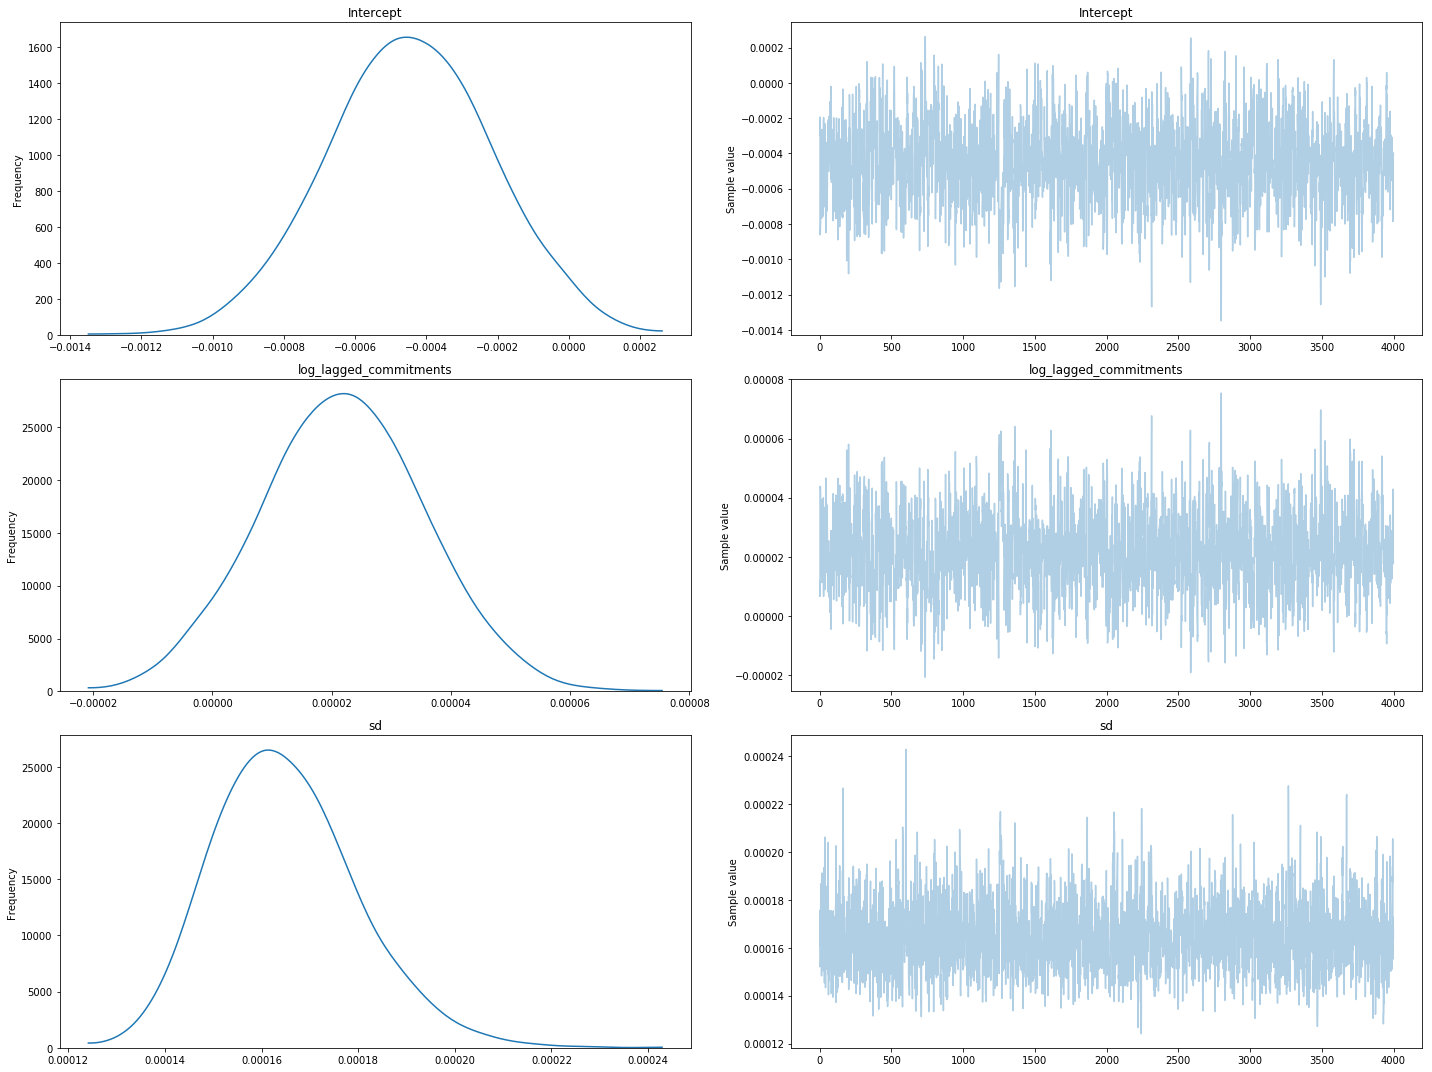

In [39]:
pm.traceplot(normal_trace, figsize = (20, 15), combined=True)
plt.savefig('Graphs\\traceplot_alt_data.png')
plt.show()

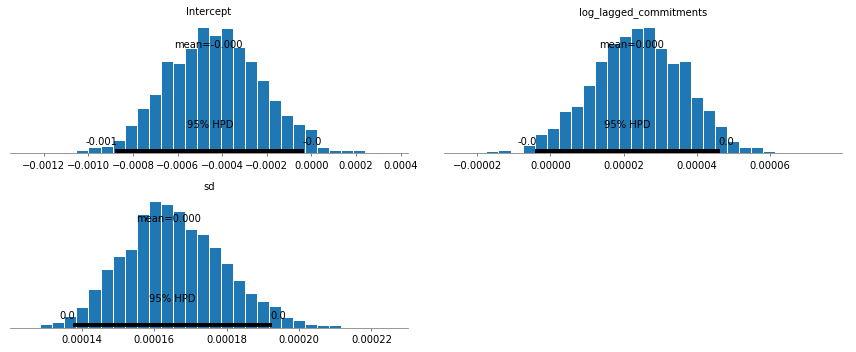

In [75]:
pm.plot_posterior(normal_trace)
plt.show()

In [32]:
normal_trace.points

<bound method MultiTrace.points of <MultiTrace: 2 chains, 2000 iterations, 4 variables>>

In [23]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.000451,0.000230,6.956990e-06,-0.000895,-0.000001,1026.904145,0.999950
log_lagged_commitments,0.000022,0.000014,4.123277e-07,-0.000005,0.000048,1024.902410,0.999953
sd,0.000165,0.000015,4.062418e-07,0.000139,0.000195,1369.337909,0.999771


In [42]:
formula = 'casulaties_standardized ~ log_lagged_commitments'

def estimate_relationship_bayesian(group_name, aid_group):
    region_year_aid = aid_group[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

    region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    with pm.Model() as normal_model:

        # The prior for the data likelihood is a Normal Distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)

        # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
        normal_trace = pm.sample(draws=1500, chains = 2, tune = 1000, njobs=-1)
        
    print(pm.summary(normal_trace))

    pm.traceplot(normal_trace, figsize = (20, 15), combined=True)
    plt.savefig('Graphs\\traceplot_reduced_%s.png' % (group_name))
    
for key, value in four_groups.items():
    print(key)
    estimate_relationship_bayesian(key, value)

HR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:02<00:00, 10.30it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


                            mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000221  0.000150  5.145991e-06 -0.000506  0.000082   
log_lagged_commitments  0.000006  0.000010  3.320393e-07 -0.000014  0.000024   
sd                      0.000067  0.000012  3.417165e-07  0.000047  0.000090   

                              n_eff      Rhat  
Intercept                986.681264  0.999886  
log_lagged_commitments   987.563311  0.999820  
sd                      1153.123017  0.999983  
LR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:00<00:00,  6.94it/s]
The acceptance probability does not match the target. It is 0.9084862551892942, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9122286117570791, but should be close to 0.8. Try to increase the number of tuning steps.


                            mean        sd  mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000391  0.001565  0.000052 -0.003436  0.002910   
log_lagged_commitments  0.000025  0.000088  0.000003 -0.000153  0.000204   
sd                      0.000333  0.000073  0.000003  0.000218  0.000485   

                             n_eff      Rhat  
Intercept               847.498216  1.002221  
log_lagged_commitments  844.800928  1.002138  
sd                      860.868493  0.999765  
LR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:48<00:00, 23.11it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


                            mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000298  0.000457  1.275029e-05 -0.001158  0.000642   
log_lagged_commitments  0.000021  0.000032  8.921733e-07 -0.000040  0.000084   
sd                      0.000248  0.000068  2.047234e-06  0.000140  0.000377   

                              n_eff      Rhat  
Intercept               1041.754286  0.999742  
log_lagged_commitments  1044.691122  0.999780  
sd                       963.468457  0.999797  
HR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:11<00:00,  6.73it/s]
The acceptance probability does not match the target. It is 0.8874672098762546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910247735163099, but should be close to 0.8. Try to increase the number of tuning steps.


                            mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000245  0.000176  5.752763e-06 -0.000590  0.000090   
log_lagged_commitments  0.000008  0.000011  3.489432e-07 -0.000013  0.000028   
sd                      0.000112  0.000011  2.960796e-07  0.000091  0.000133   

                              n_eff      Rhat  
Intercept                958.315477  0.999831  
log_lagged_commitments   959.142734  0.999831  
sd                      1182.737442  1.000582  


In [ ]:
# TODO LIST

# 3. Select projects based on the 4 subcategories derived above.
# Projects with: donor is in one of the first classification group.
# Start year and area is in one of the second classification groups.

#                        High adaptability              Low adaptability
#
# High receptivity           n                                 n2
#
# Low receptivity            n3                                n4



# 4. THINK ABOUT INFERENCE PROBLEM, MATCHING PROBLEM, CREATING CONTROL AND TREATMENT GROUPS.

In [3]:
drc = pd.read_excel('Data\\south_of_sahara\\DRC_Conflict_27June2012.xlsx', header = 0, index_col = 0)
uganda = pd.read_excel('Data\\south_of_sahara\\Uganda_Conflict_27June2012.xlsx', header = 0, index_col = 0)
ethiopia = pd.read_excel('Data\\south_of_sahara\\Ethiopia_Conflict_27June2012.xlsx', header = 0, index_col = 0)
sudan = pd.read_excel('Data\\south_of_sahara\\Sudan_Conflict_27June2012.xlsx', header = 0, index_col = 0)
burundi = pd.read_excel('Data\\south_of_sahara\\Burundi_Conflict_20June2012.xlsx', header = 0, index_col = 0)

ethiopia.drop(ethiopia[ethiopia['precision'] == '.'].index, inplace = True)
burundi.drop(burundi[burundi['precision'] == '        .'].index, inplace = True)

all_provinces = gpd.read_file('Data\\Shapefiles\\ADM1\\compiled.shp')

drc = drc[drc['precision'] <=6]
uganda = uganda[uganda['precision'] <=6]
ethiopia = ethiopia[ethiopia['precision'] <=6]
sudan = sudan[sudan['precision'] <=6]
burundi = burundi[burundi['precision'] <=6]

In [4]:
def recode_commitments(df):
    """
        Commitments are coded for for all locations within a project. 
        To arrive at an average per location divide the value over numbloc
    """
    df['usdcr'] = df['usdcr'] / df['numbloc']
    df['usdco'] = df['usdco'] / df['numbloc']
    return df

def geocode(df):
    geometry = [Point(xy) for xy in zip(df.long, df.lat)]
    gdf = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = geometry)
    gaid = gpd.sjoin(gdf, all_provinces, how="inner")
    return gaid

In [5]:
countries = [drc, uganda, ethiopia, sudan, burundi]
geoaid = [geocode(country) for country in countries]
geoaid = list(map(recode_commitments, geoaid))

geoaid_df = pd.DataFrame()
for country in geoaid:
    geoaid_df = geoaid_df.append(country)

In [6]:
burundi['usdco'].max()

46855903.0

In [9]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        temp = copy.deepcopy(last_row)
        temp['year'] += 1
        temp[new_name] = temp[column_name]
        temp[column_name] = np.nan

        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [10]:
lagged_geoaid = pd.DataFrame()
for country in geoaid:
    lagged_geoaid = lagged_geoaid.append(add_lag(country[['year', 'NAME_1', 'usdcr']].groupby(['NAME_1', 'year']).sum(), 'usdcr', 'usdcr_lagged'))

lagged_geoaid = lagged_geoaid[lagged_geoaid['year'] >= 1999]

In [16]:
aggregate_conflict = pd.read_csv('Data\\conflict_data\\gedevents-2018-07-13.csv', header = 0, index_col = 0)
geometry = [Point(xy) for xy in zip(aggregate_conflict.longitude, aggregate_conflict.latitude)]
aggregate_conflict = gpd.GeoDataFrame(aggregate_conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

In [17]:
temp = pd.DataFrame()
aggregate_conflict = gpd.sjoin(aggregate_conflict, all_provinces, how = 'inner')

In [18]:
aggregate_conflict = aggregate_conflict.drop(aggregate_conflict[aggregate_conflict['NAME_1'].isnull()].index)
aggregate_region_year_casualties = aggregate_conflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
aggregate_region_year_casualties  = add_lag(aggregate_region_year_casualties, 'best_est', 'lagged_casualty')

In [19]:
aid_and_conflict = pd.merge(aggregate_region_year_casualties, lagged_geoaid, on = ['NAME_1', 'year'])

In [20]:
aid_and_conflict['lagged_commitments'] = np.log(aid_and_conflict['usdcr_lagged'])

In [21]:
result = sm.ols(formula = 'best_est ~ lagged_casualty + lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               best_est   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     51.40
Date:                Tue, 28 Aug 2018   Prob (F-statistic):           1.68e-20
Time:                        17:10:54   Log-Likelihood:                -2847.5
No. Observations:                 386   AIC:                             5701.
Df Residuals:                     383   BIC:                             5713.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            132.0104    122.139      1.081      0.280    -108.137     372.158
lagged_casualty        0.4371      0.043     10.136      0.000       0.352       0.522
lagged_commitments    -3.4355      8.339     -0.412      0.681     -19.831      12.960
==============================================================================
Omnibus:                      582.778   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147790.196
Skew:                           7.845   Prob(JB):                         0.00
Kurtosis:                      97.567   Cond. No.                     3.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
def plot_distances_new(year, aid_df):
    min_dists = []
    for aid_project in aid_df[aid_df['year'] == year]['geometry']:
        min_dists.append(min(aggregate_conflict[aggregate_conflict['year'] == year + 1]['geometry'].distance(aid_project)))
    
    min_dists = pd.Series(min_dists) * 110
    
    #min_dists.plot.density()
    
    #plt.show()
    #print(min_dists.mean())
    #print(min_dists.median())
    return min_dists

Democratic Republic of the Congo


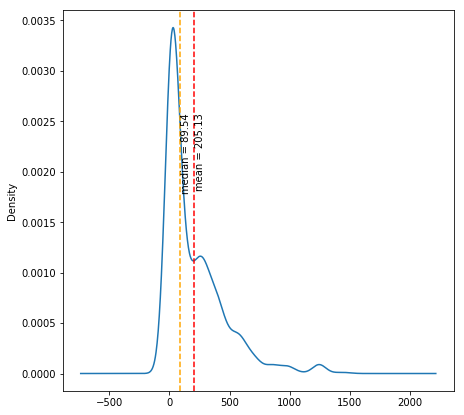

Uganda


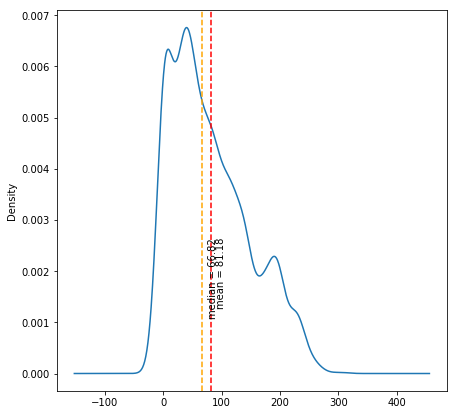

Ethiopia


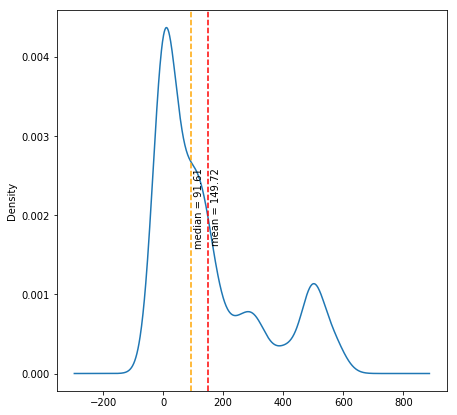

Sudan


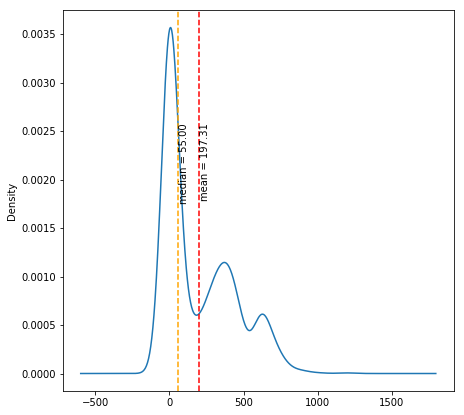

Burundi


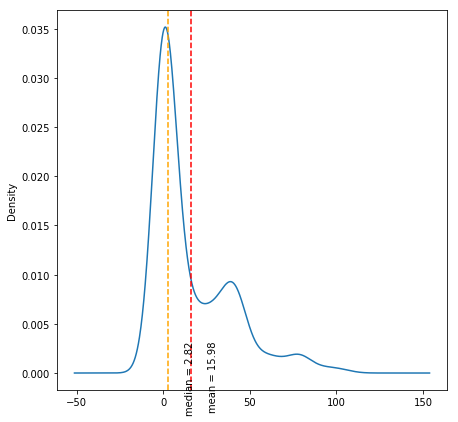

In [52]:
for country in geoaid:
    print(country['NAME_0'].iloc[0])
    country_dist = pd.Series()
    for year in range(1999, 2009):
        country_dist = country_dist.append(plot_distances_new(year, country))
    
    
    
    fig = plt.figure(figsize = (7, 7))
    
    country_dist.plot.density()
    
    plt.axvline(country_dist.mean(), color = 'r', linestyle = '--')
    plt.text(country_dist.mean()+10,0.0025,'mean = {0:.2f}'.format(country_dist.mean()), rotation=90, fontsize=10)

    plt.axvline(country_dist.median(), color = 'orange', linestyle = '--')
    plt.text(country_dist.median()+10,0.0025,'median = {0:.2f}'.format(country_dist.median()), rotation=90, fontsize=10)

    plt.savefig('Graphs\\NN_distance_{}.png'.format(country['NAME_0'].iloc[0]), bbox_inches='tight')
    plt.show()

In [45]:
geoaid

[         event id                           rname  recipient_id   dname  \
 248550  248550.01  CONGO, DEMOCRACTIC REPBULIC OF           554  AUSTRI   
 204002  204002.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 204003  204003.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 204005  204005.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 221699  221699.01  CONGO, DEMOCRACTIC REPBULIC OF           554   SPAIN   
 222690  222690.01  CONGO, DEMOCRACTIC REPBULIC OF           554   SPAIN   
 190610  190610.01  CONGO, DEMOCRACTIC REPBULIC OF           554   SPAIN   
 329790  329790.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 330713  330713.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 331144  331144.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 331146  331146.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 331152  331152.01  CONGO, DEMOCRACTIC REPBULIC OF           554  BELGIU   
 338377  338

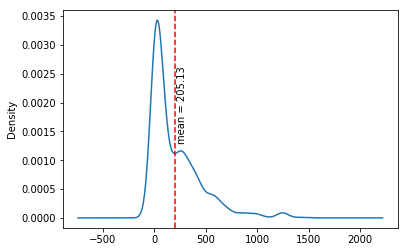

In [43]:
country_dist.plot.density()
plt.axvline(country_dist.mean(), color = 'r', linestyle = '--')
plt.text(country_dist.mean()+20,0.0025,'mean = {0:.2f}'.format(country_dist.mean()), rotation=90, fontsize=10)

plt.show()